In [387]:
import pandas as pd
import numpy as np
from datetime import datetime
import utils
import importlib
import math 
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

importlib.reload(utils)

<module 'utils' from '/Users/devyn/Computer Science/Data Science/da8_personal_project/utils.py'>

# Qunatified Self Project using Strava  
### Devyn Hubbs, CPSC 222 Spring 2025  

This project is a piece included in the CPSC 222 course at Gonzaga University. The purpose of the project is to explore and analyze personally collected longitudinal data.  

The focus of this project is on data collected from a personal **Strava** account (`devyn_strava_activities.csv`). The data includes over 100 fitness activities recorded in the past school year. The inspiration behind using this data is I joined the Gonzaga Women's Rowing Team my freshman year of college, and I just started seriously recording my workouts using **Strava** this year. Seeing as I had never rowed before, the improvement curve was expected to very intense at first. I wanted to see if I could find some correlations between time and fitness level, as well as general correlations between rowing-based workouts versus other workouts.  

A secondary data set that will be used in this project includes the daily weather of Spokane, WA (`Spokane_daily_weather.csv`). This was collected from a **MeteoStat** URL through **Mapbox.com**. This code was collected and modified from my previous DA5 project. The purpose of this dataset is to help visualize the possibility of different workout trends based on daily weather. Especially with an outside sport, it is interesting to see if the weather has a big effect on the total amount of active time for a workout, or rather, no effect at all.  

Some notable attributes in `devyn_strava_activities.csv` are:  
* **Activity Date** (datetime object)
* **Activity Type** (string)
* **Distance** (float, string)
    * **Note: I changed my preferences from miles to meters halfway through this year.*  
* **Relative Effort** (float)
* **Moving Time** (float)
* **Average Heart Rate** (float) 

## Collecting and Cleaning the Data  

For both datasets, the cleaning process includes removing columns with more than **25%** of null values, as well as manually removing columns that don't clearly help this project. Both cleaned data sets are written to a `.csv` file. 

In [388]:
utils.collectStravaData()
utils.collectWeatherData()

/Users/devyn/Computer Science/Data Science/da8_personal_project/utils.py:137: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_cleaned = df_cleaned[df_cleaned["Activity Date"] <= endingDate]


## Merged Data  

Both datasets contain a column of `datetime` objects named `Activity Date`. The purpose of merging these two datasets on date will allow in the future to analyze the connection between temperature and overall fitness effort throughout this year. The two datasets are cut to match each others date-range, and then merged with an *inner* join. 

In [389]:
strava_df = pd.read_csv("devyn_CLEANED_strava_activities.csv")
weather_df = pd.read_csv("Spokane_CLEANED_daily_weather.csv")

merged_df = pd.merge(strava_df, weather_df, on="Activity Date", how="inner")
merged_df.to_csv("merged_data.csv")

# Exploratory Data Analysis 

## Strava Activity Stats  

The following statistics are meant to possibly show some unexpected correlations among the data. For example, I wonder if there is difference in the relationship between average temperature and average RE in general versus only for rowing activities.

In [390]:
stats_ser = utils.calculateStravaStats()
print(stats_ser)

Total Activities                     158.00
Average Active Time (in minutes)      63.81
Average Temperature (F)               46.24
Average Heart Rate                   141.95
Average Relative Effort               70.09
Relative Effort StDev                 49.98
Total Rowing Activities               96.00
Average Rowing Active Time (mins)     72.14
Average RE for Rowing                 83.80
Average Temp for Rowing (F)           49.33
Total Ride Activities                 22.00
Average Ride Active Time (mins)       45.77
Average RE for Riding                 60.41
dtype: float64


**Observations:**  
* The average RE for rowing activities is higher than the overall RE, as well as the temperature is slightly warming on average during rowing activities
    * **Note: something that could be swaying the data is that over half of the data is collected from rowing activities, with a total of 96 rowing activities.*
* Overall, my fitness effort is significantly increased in rowing activities versus ride activities 
* My team's standard for "steady state" workouts (the equivalent of jogging for running) is a goal of a 150-160 HR. My average heart rate is a good amount below that. 

## Visualization  

Below is shown the relationship between active time of each type of workout activity compared against the average temperature of the day of the workout. This is inspired by the question of if wether is a factor into how long our practices are or not. 

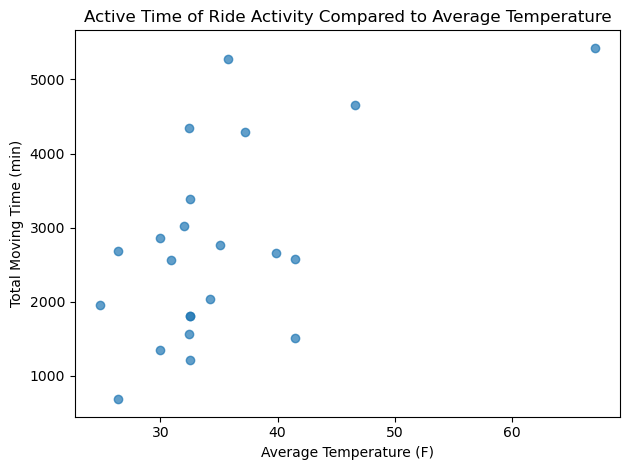

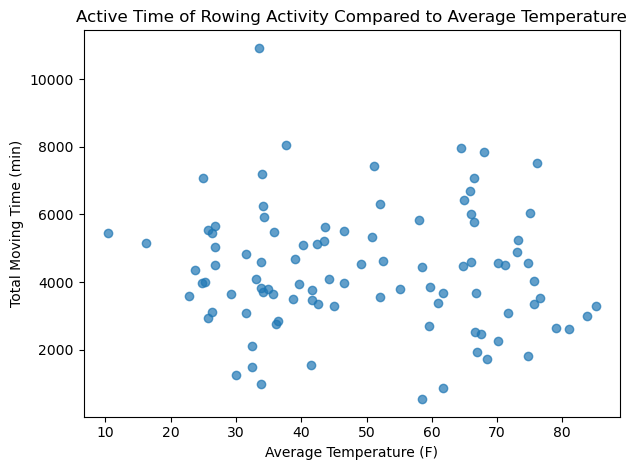

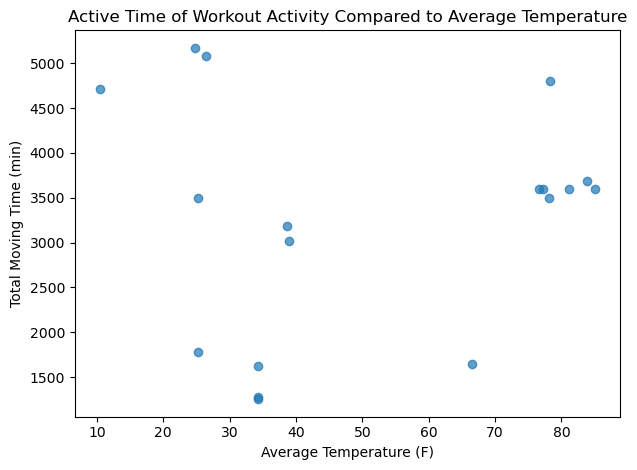

In [391]:
activity_df = merged_df.groupby("Activity Type")
activity_options = activity_df.groups.keys()

for activity in activity_options:
    group = activity_df.get_group(activity)
    utils.createTempScatter(activity, group)

**Obervations:**  
* There is no obvious relationship between the two attributes. It would make sense to see an increase of rowing minutes as the weather increases, but the reality is we live in a rather cold place and the rowing team will row in almost every weather condition. 
* Once it got warmer, I did not spend much time biking. This could be because I liked to run outside, or bring a rowing machine outside and row instead. 

Below is shown the relationship between average heart rate in comparison to total active time of a workout for each activity type. This is inspired by the hypothesis that shorter workouts tend to be more high-intensity, therefore with a higher average heart rate.

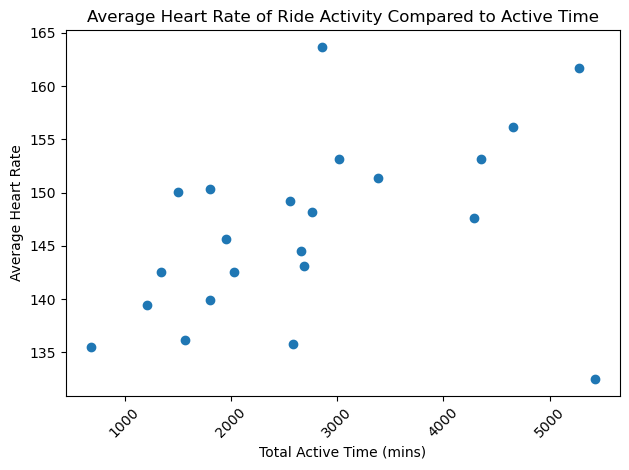

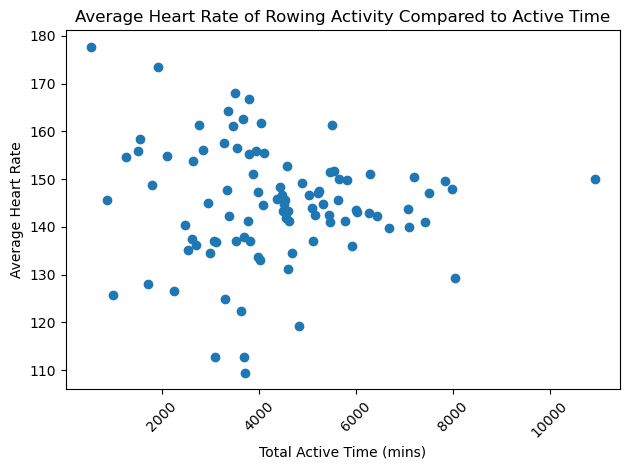

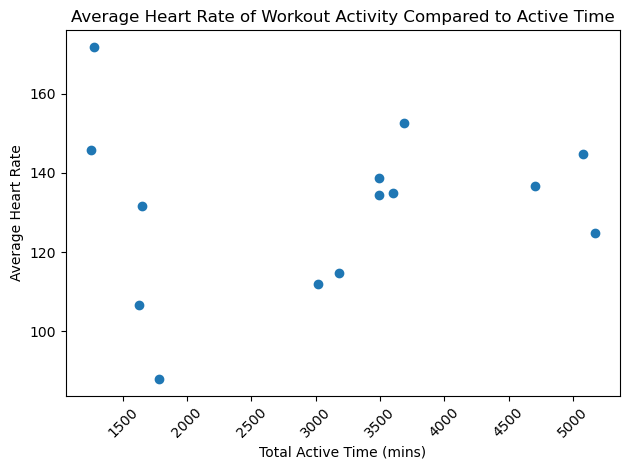

In [392]:
for activity in activity_options:
    group = activity_df.get_group(activity)
    utils.createHRScatter(activity, group)

**Observations:**  
* Surprisingly, there doesn't seem to be any correlation between average heart rate and active time, except for possibly ride activities. 
* The  majority of rowing activities rest between the 140-170HR, which is exactly where we are trained to be for a majority of our "steady state" workouts. 
* There is not enough data for workout activities other than rowing to notice any pattern. 

WRITE HERE

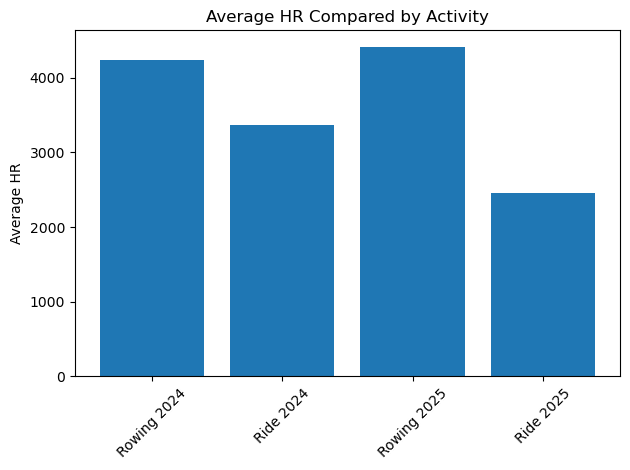

In [393]:
rowing_df = activity_df.get_group("Rowing")
ride_df = activity_df.get_group("Ride")

utils.averageHRBar(rowing_df, ride_df)

WRITE HERE

Below is shown the comparison of relative effort by month of rowing activities over the span of the collection timeline. 

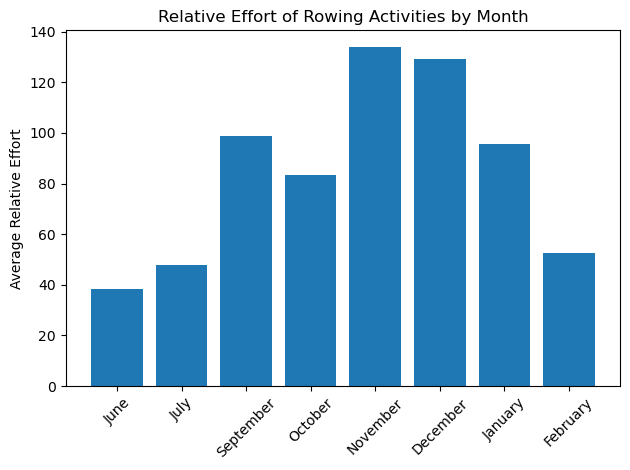

In [394]:
utils.monthlyRowBar(rowing_df)

This trend could be due to the fact that, starting in November, we begin to train for racing season. This means shorter workouts that require more effort. Our winter season is when the most intense workouts happen, especially since they require us to build more fitness that we might not have had in the fall. 

## Hypothesis Testing   

**The Question:** Is the mean average active minutes for Rowing Activities in December less than the mean average active minutes for Rowing Activities in January?  


**Step 1:**  
Identify the null hypothesis and alternative hypothesis.  

$H_{0}: \mu_{D} \ge \mu_{J}$   
$H_{1}: \mu_{D} < \mu_{J}$  

**Step 2:**  
Select the level of significance.  

$\alpha = 0.05$  

**Step 3:**  
Select the appropiate test statistic.  

$t=\frac{\overline{X_{1}}-\overline{X_{2}}}{\sqrt{s_{p}^{2}(\frac{1}{n_{1}}+\frac{1}{n_{2}})}}$   

**Step 4:** 
Formulate the decision rule.  

$df = n_{1} + n_{2} - 2$  
*df = 58, t-critical = 1.671*  

*If t-critical > 1.671 or t-critical < -1.671, then reject $H_{0}$*  

**Step 5:**  
Make a decision. 

In [395]:
rowing_df = activity_df.get_group("Rowing").copy()
rowing_df["Activity Date"] = pd.to_datetime(rowing_df["Activity Date"])

startDec = datetime.strptime("2024-12-1", "%Y-%m-%d")
endDec = datetime.strptime("2024-12-31", "%Y-%m-%d")
december_df = rowing_df[(rowing_df["Activity Date"] >= startDec) & (rowing_df["Activity Date"] <= endDec)]

startJan = datetime.strptime("2025-1-1", "%Y-%m-%d")
endJan = datetime.strptime("2025-1-31", "%Y-%m-%d")
january_df = rowing_df[(rowing_df["Activity Date"] >= startJan) & (rowing_df["Activity Date"] <= endJan)]

t_computed_6, p_val_6 = stats.ttest_ind(december_df["Moving Time"], january_df["Moving Time"], equal_var=False)
print("t_computed: ", t_computed_6, "\np_val: ", p_val_6)
alpha_6 = 0.05
if p_val_6 < alpha_6: 
    print("Reject H0") 
else: 
    print("Do not reject H0")

t_computed:  -2.88066862316203 
p_val:  0.008454751140829893
Reject H0


**Since t-critical < -1.671, then reject $H_{0}$**   
**With a 0.05 significance level, it seems that the average active minutes of Rowing Activity in December was less than the average active minutes in January.**  

Observations;
* This most likely is due to two factors: 
    * We have a longer break in December than in January
    * I was injured for some of December and didn't row 

## Classification of the Dataset

The classification approach I want to take is inspired by one of the visualizations from earlier. In the representation of Average Relative Effort of Rowing Activities by month, it could be concluded to classify a Rowing activity as *out of season* (June-October) or *preseason* (November-March).

This approach will have a little extra difficulty as the labels of *out of season* and *preseason* aren't included in the data. I will have to correlate the months in the data with these two labels to then create a machine learning model. 

EXPLAIN HERE

In [396]:
df = pd.read_csv("devyn_CLEANED_strava_activities.csv")
activity_df = df.groupby("Activity Type")
rowing_df = activity_df.get_group("Rowing")
rowing_df["Activity Date"] = pd.to_datetime(rowing_df["Activity Date"])
rowing_df.dropna(inplace=True)

# Create a label for "out of season" and "preseason" for the dataset 
season_labels = []

# Assign a label based on month
for date in rowing_df["Activity Date"]:
    month = date.month
    if month in [5, 6, 7, 8]:
        season_labels.append("out of season")
    else:
        season_labels.append("preseason")

# Add the list as a new column
rowing_df["Season"] = season_labels

# For the sake of machine learning
rowing_df.drop(["Activity Name", "Activity Date", "Activity ID", "Activity Type"], axis="columns", inplace=True)

/var/folders/v1/y4hhmnjs1x72zr2lddjwt7sc0000gn/T/ipykernel_5338/2802160149.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rowing_df["Activity Date"] = pd.to_datetime(rowing_df["Activity Date"])
/var/folders/v1/y4hhmnjs1x72zr2lddjwt7sc0000gn/T/ipykernel_5338/2802160149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rowing_df.dropna(inplace=True)
/var/folders/v1/y4hhmnjs1x72zr2lddjwt7sc0000gn/T/ipykernel_5338/2802160149.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [397]:
X = rowing_df.drop(["Season"], axis="columns")
y = rowing_df["Season"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### kNN Classifier

In [398]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
y_predict = knn_clf.predict(X_test)
acc = accuracy_score(y_test, y_predict)

print("y_predict: ", y_predict)
print("accuracy: ", acc)

y_predict:  ['preseason' 'preseason' 'preseason' 'preseason' 'preseason'
 'out of season' 'preseason' 'preseason' 'preseason' 'preseason'
 'preseason' 'preseason' 'preseason' 'preseason' 'preseason' 'preseason'
 'preseason' 'preseason' 'preseason' 'preseason' 'preseason' 'preseason'
 'preseason' 'out of season']
accuracy:  0.75


### Decision Tree Classifier

In [399]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("y_predict: ", y_pred)
print("accuracy: ", accuracy)

y_predict:  ['out of season' 'preseason' 'out of season' 'preseason' 'preseason'
 'preseason' 'preseason' 'preseason' 'preseason' 'preseason' 'preseason'
 'out of season' 'out of season' 'out of season' 'preseason' 'preseason'
 'preseason' 'preseason' 'preseason' 'preseason' 'preseason' 'preseason'
 'preseason' 'out of season']
accuracy:  0.75


OBSERVATIONS

## Conclusion